<a href="https://colab.research.google.com/github/irmakkoseoglu/PhishGuard-Lite/blob/main/Simple%20Phishing%20URL%20Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛡️ PhishGuard Lite: Simple Phishing URL Detector

A lightweight machine learning project that detects phishing websites based on URL patterns using basic feature engineering and a Naive Bayes classifier.

**Step 1: Download the Dataset from Kaggle**

To use a Kaggle dataset inside Google Colab, we need to upload the kaggle.json file containing your API credentials. Then, we configure the environment and download the dataset.

In [40]:
from google.colab import files
files.upload()  # Upload kaggle.json (Kaggle API credentials)


Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"rmakkoseoglu","key":"44ffd2a18f08cc53d602047f2c16037e"}'}

In [41]:
!mkdir -p ~/.kaggle                                         # Create a directory for the Kaggle API
!cp kaggle.json ~/.kaggle/                                  # Move the API key to the correct location
!chmod 600 ~/.kaggle/kaggle.json                            # Set permissions to secure the key
!pip install kaggle                                         # Install Kaggle Python library
!kaggle datasets download -d lilly1739/phishing-dataset-url # Download the dataset
!unzip phishing-dataset-url.zip                             # Unzip the downloaded file


Dataset URL: https://www.kaggle.com/datasets/lilly1739/phishing-dataset-url
License(s): unknown
phishing-dataset-url.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  phishing-dataset-url.zip
replace phishing_missingv.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Step 2: Load the Dataset and Perform Initial Exploration**

We load the phishing dataset using pandas and perform a quick inspection to understand its structure, including the number of rows and columns.

In [45]:
import pandas as pd

df = pd.read_csv('phishing_missingv.csv') # Load the dataset
df.head() # Display the first 5 rows to preview the data


,domain,ranking,isIp,valid,activeDuration,urlLen,is@,isredirect,haveDash,domainLen,nosOfSubdomain,label,isip
0,www.voting-yahoo.com,10000000,0,0,0,20,0.0,0.0,1.0,20.0,2,1,NaN
1,www.zvon.org/xxl/WSDL1.1/Output/index.html,194914,0,1,7305,42,0.0,0.0,0.0,12.0,2,0,NaN
2,tecportais.com/file-security-update-infonfmati...,10000000,0,0,0,155,0.0,0.0,0.0,14.0,1,1,NaN
3,bima.astro.umd.edu/nemo/linuxastro/,7001,0,0,0,35,0.0,0.0,0.0,18.0,3,0,NaN
4,huarui-tec.com/js/?us.battle.net/login/en/?ref...,10000000,0,1,730,79,NaN,0.0,1.0,14.0,1,1,NaN


In [46]:
# Show the number of rows and columns
print(f"Rows number: {df.shape[0]}")
print(f"Columns number: {df.shape[1]}")

Rows number: 95910
Columns number: 13


In [47]:
# Display dataset info including column names, non-null counts, and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95910 entries, 0 to 95909
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   domain          95910 non-null  object 
 1   ranking         95910 non-null  int64  
 2   isIp            95910 non-null  int64  
 3   valid           95910 non-null  int64  
 4   activeDuration  95910 non-null  int64  
 5   urlLen          95910 non-null  int64  
 6   is@             81524 non-null  float64
 7   isredirect      91115 non-null  float64
 8   haveDash        91115 non-null  float64
 9   domainLen       92074 non-null  float64
 10  nosOfSubdomain  95910 non-null  int64  
 11  label           95910 non-null  int64  
 12  isip            0 non-null      float64
dtypes: float64(5), int64(7), object(1)
memory usage: 9.5+ MB


**Step 3: Handle Missing Values & Explore Target Distribution**

In this step, we inspect missing values in the dataset, clean them by filling with the median (for numerical features), and drop columns that are completely empty. Finally, we visualize the distribution of the target labels (label) to see the balance between phishing and safe URLs.

In [48]:
# Check for missing values
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100

# Create a summary table for missing values
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage (%)': missing_percent})
print(missing_df.sort_values(by='Percentage (%)', ascending=False))

                Missing Count  Percentage (%)
isip                    95910      100.000000
is@                     14386       14.999479
haveDash                 4795        4.999479
isredirect               4795        4.999479
domainLen                3836        3.999583
activeDuration              0        0.000000
valid                       0        0.000000
isIp                        0        0.000000
ranking                     0        0.000000
domain                      0        0.000000
urlLen                      0        0.000000
nosOfSubdomain              0        0.000000
label                       0        0.000000


In [49]:
# Drop completely empty columns
df.drop(columns=['isip'], errors='ignore', inplace=True)

In [51]:
# Fill missing values in selected columns with median
for col in ['is@', 'isredirect', 'haveDash', 'domainLen']:
    df[col] = df[col].fillna(df[col].median())

# Check if any missing values remain
print(df.isnull().sum())


domain            0
ranking           0
isIp              0
valid             0
activeDuration    0
urlLen            0
is@               0
isredirect        0
haveDash          0
domainLen         0
nosOfSubdomain    0
label             0
dtype: int64


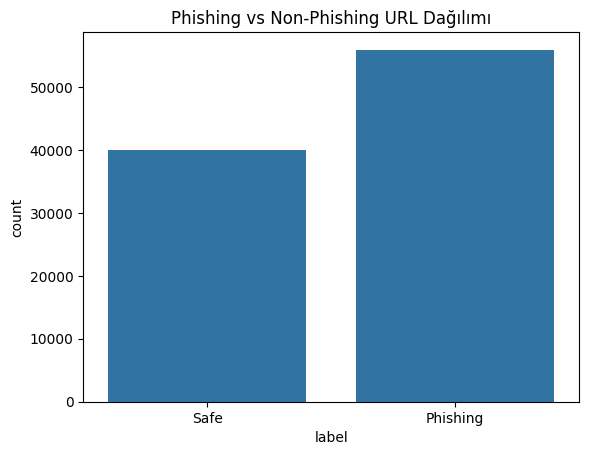

In [52]:
# # Visualize label distribution 1 = Phishing, 0 = Safe
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='label')
plt.title("Phishing vs Non-Phishing URL Dağılımı")
plt.xticks([0, 1], ['Safe', 'Phishing'])
plt.show()


**Step 4: Train a Simple Naive Bayes Classifier**

Now that our data is clean, we train a basic Gaussian Naive Bayes model to classify URLs as phishing or safe. We split the data into training and testing sets (80/20), fit the model, and evaluate its performance using accuracy, classification report, and confusion matrix.

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [53]:
# Features and target
X = df.drop(columns=['domain', 'label'])  # 'domain' is text-based and not useful for the model
y = df['label']


In [54]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [55]:
# Train the model
model = GaussianNB()
model.fit(X_train, y_train)


GaussianNB()

In [57]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8308309873840058

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81      7810
           1       0.89      0.81      0.85     11372

    accuracy                           0.83     19182
   macro avg       0.83      0.84      0.83     19182
weighted avg       0.84      0.83      0.83     19182


Confusion Matrix:
 [[6722 1088]
 [2157 9215]]


**Step 5: Visualizing Model Performance**

We further analyze our model's performance using:



1.   **Confusion Matrix**: To see the count of true positives, true negatives, false positives, and false negatives.
2.   **Bar Chart** of key performance metrics: Accuracy, Precision, Recall, and F1 Score.


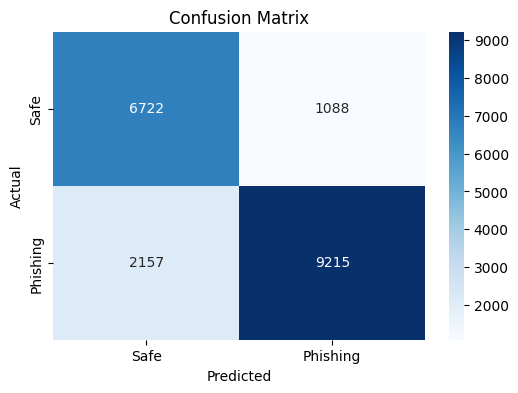

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Safe", "Phishing"], yticklabels=["Safe", "Phishing"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


<ipython-input-59-3c9e4ef9ca80>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=names, y=metrics, palette='pastel')


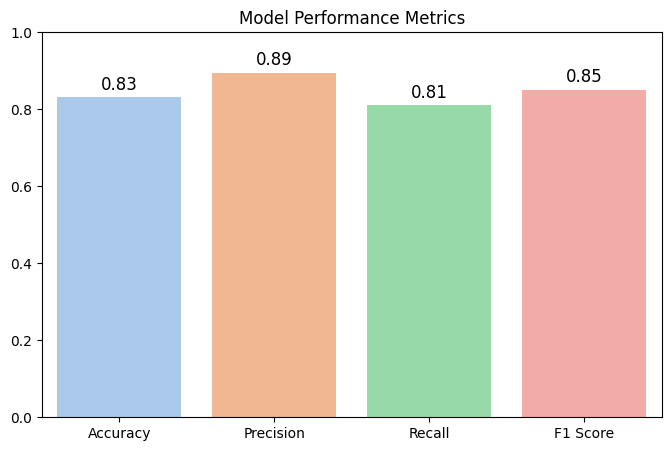

In [59]:
# Import additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metric scores
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Plot bar chart of metrics
metrics = [accuracy, precision, recall, f1]
names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(8,5))
sns.barplot(x=names, y=metrics, palette='pastel')
plt.ylim(0, 1)
plt.title("Model Performance Metrics")
for i, v in enumerate(metrics):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)
plt.show()
